# Kings County Housing Prices Prediction

# Overview
This project created a model that can predict the prices of homes sold in the Seattle, WA area. All kinds of features related to the houses are provided. Linear and non-linear machine learning methods in scikit-learn library are used to construct the models with selected data. Houseing prices are predicted within a reasonable error range.

# Business Understanding
A real estate agency in Seattle WA wants to predict the housing prices in order to develop market strategies and target potential customers. The prices of houses with various features are provided for year 2014-2015. Geographical data can also be fetched to enrich the pool of features. The study of population structure of residents is also an important factor for the prediction, but it is outside the scope of this project.

# Data Understanding

## Read in Modules and Data

In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pickle

import geopandas as gpd
# homemade module
import homebrew as hb

In [165]:
df = pd.read_csv('Data/kc_house_data_train.csv', index_col=0)

## Exploratory Data Analysis
This step is to understand the information contained within the data. Become familiar with the data. Data visualizations is created to determine if there are any relationships between the features and the target variables. Look to see if there are any extreme values.

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


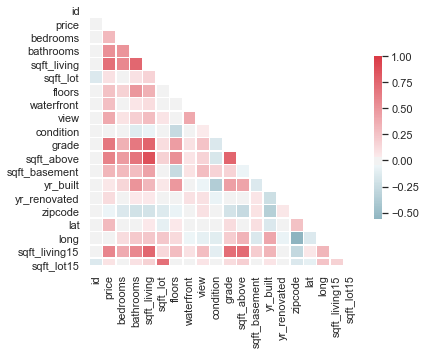

In [64]:
sns.set(style="white")

corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(6, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
#plt.savefig('Images/heatmap.jpeg', format='jpeg')

In [69]:
col = ['bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition','grade',
'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated','sqft_living15', 'sqft_lot15']

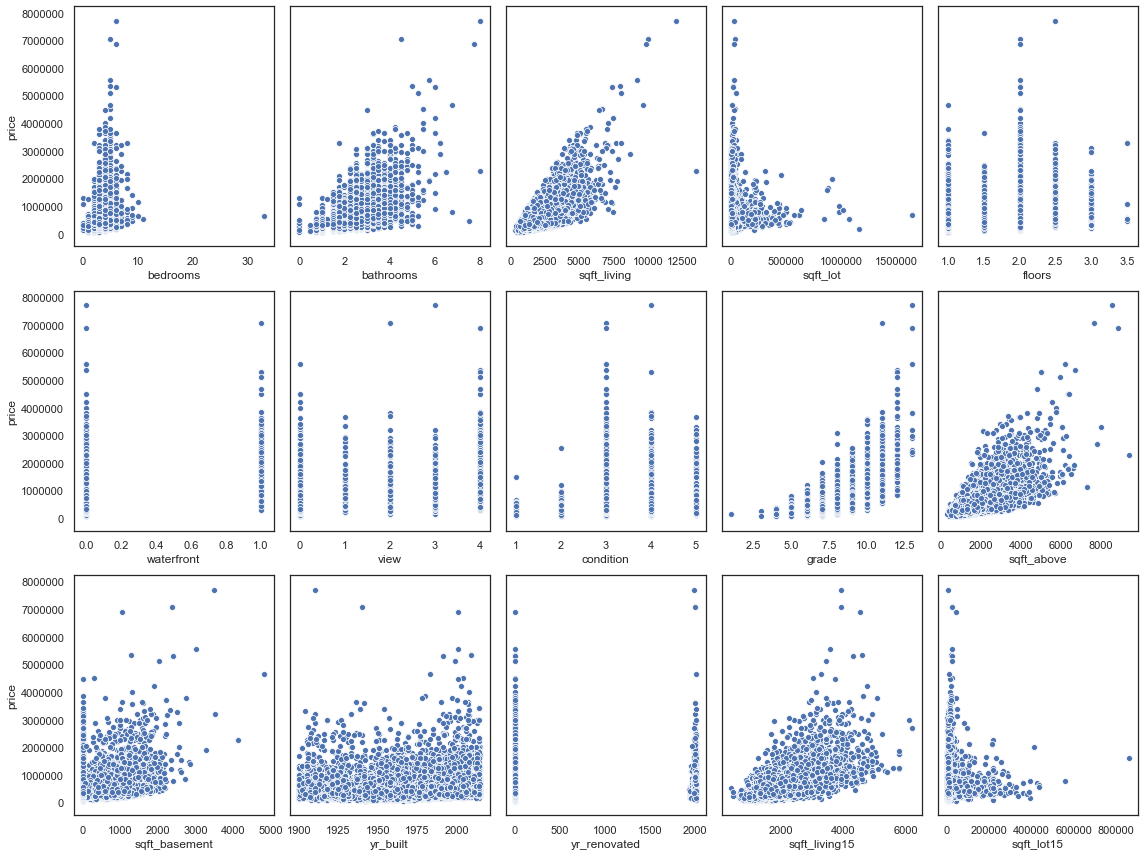

In [108]:
fig, axes = plt.subplots(3,5, sharey=True, figsize=(16,12))
for ax, c in zip(axes.flat, col):
    sns.scatterplot(data=df, x=c, y='price', ax=ax)
plt.tight_layout()
#plt.savefig('Images/mix.png', format='png')

## Geopandas

In [331]:
kc = gpd.read_file('Data/Zip_Codes.geojson')
zip_pr = df.groupby('zipcode').price.mean()
kc_zip = kc.join(zip_pr, on='ZIP', how='inner')

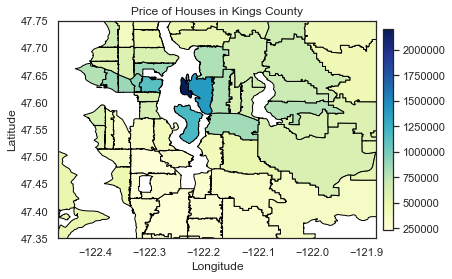

In [359]:
# gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.long, df.lat))
# gdf.plot(ax=ax, cmap='YlGnBu', legend=True, markersize=5)
fig, ax = plt.subplots() #figsize=(12,6)
kc_zip.plot(column='price', cmap='YlGnBu', edgecolor='black', ax=ax)

color_bar = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=zip_price.min(), vmax=zip_price.max()))
plt.colorbar(color_bar, fraction=0.03, pad=0.02)
plt.axis('equal')
ax.set_ylim(47.35, 47.75)
ax.set_xlim(-122.25, -122.1)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.title('Price of Houses in Kings County')
#plt.savefig('Images/ks.png', format='png')

## Statistical Test
Three statistical tests are preformed on the data set. Null hypothesis and alternative hypothesis are constructed for the tests. Data visualizations are created to explain the data and understand the features.

### Two-Sample T-test (Welch’s T-test)
H0: The sample mean of prices of the houses with a view to a waterfront or not are the same. \
Ha: The sample mean of prices of the houses with a view to a waterfront or not are different.

Text(0.5, 1.0, 'Mean Price with a View to a Waterfront or not')

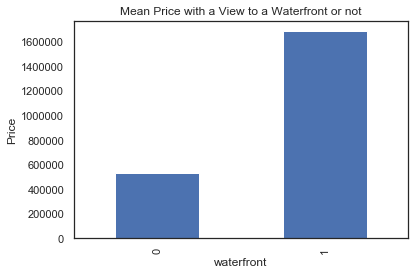

In [72]:
df.groupby('waterfront').price.mean().plot.bar()
plt.ylabel('Price')
plt.title('Mean Price with a View to a Waterfront or not')
#plt.savefig('Images/waterfront.jpeg', format='jpeg')

In [73]:
t, p = stats.ttest_ind(df[df.waterfront==0].price, df[df.waterfront==1].price, equal_var=False)
p        

6.940441256090536e-23

p < .05, so the null hypothesis is rejected. The sample mean of prices of the houses with a view to a waterfront or not are different.

### Chi-square Test
H0: Different conditions of the houses has been viewed the same time. \
Ha: Different conditions of the houses has been viewed different time.

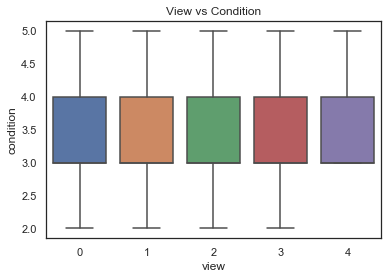

In [79]:
sns.boxplot(data=df, x='view',y='condition', showfliers=False)
plt.title('View vs Condition')
#plt.savefig('Images/test.png')

In [81]:
df.groupby(['condition', 'view']).size().unstack().iloc[:,0:2]

view,0,1
condition,,
1,22.0,1.0
2,133.0,1.0
3,10220.0,153.0
4,4011.0,83.0
5,1185.0,26.0


In [82]:
contin_table = df.groupby(['condition', 'view']).size().unstack().iloc[:,0:2]
stat, p, dof, expected = stats.chi2_contingency(contin_table)
critical = stats.chi2.ppf(0.95, dof)
critical, stat, p

(9.487729036781154, 8.978819849544736, 0.06163106973068126)

p > 0.5 and stat < critical value, so it fails to reject the the null hypothesis. It shows no dependence between conditions of the houses and view.

### ANOVA
H0: The sample mean of prices of the houses with different grading are the same. \
Ha: The sample mean of prices of the houses with different grading are different.

In [85]:
anova = ols('price ~ grade', data=df).fit()
table = sm.stats.anova_lm(anova, typ=2)
table

,sum_sq,df,F,PR(>F)
grade,1.069446e+15,1.0,13796.712242,0.0
Residual,1.340071e+15,17288.0,NaN,NaN


p < .05, so the null hypothesis is rejected. The sample mean of prices of the houses with different grading are different.

In [102]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

model = pairwise_tukeyhsd(df.price, df.grade)
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,3,26500.0,0.9,-999555.33,1052555.33,False
1,4,68638.6364,0.9,-787960.6905,925237.9632,False
1,5,101837.2448,0.9,-738112.2851,941786.7746,False
1,6,160682.0388,0.9,-677342.7694,998706.8471,False
1,7,260526.7224,0.9,-577302.2605,1098355.7053,False
1,8,401010.4917,0.9,-436846.5763,1238867.5598,False
1,9,632161.7851,0.3635,-205808.4241,1470131.9944,False
1,10,930903.3124,0.015,92663.6984,1769142.9265,True
1,11,1365966.9561,0.001,526884.1947,2205049.7176,True
1,12,2172346.9444,0.001,1328778.4856,3015915.4033,True


# Data Preparation

## Data Cleaning & Feature Engineering
The rows with extreme values is considered. Identify categorical variables in the data set and create dummy columns to numeric format through one-hot encoding. New features are generated.

### Date

In [109]:
df['year'] = pd.to_datetime(df.date).dt.year
df['month'] = pd.to_datetime(df.date).dt.month
month = df.groupby('month').price.describe()

Text(0, 0.5, 'mean of price')

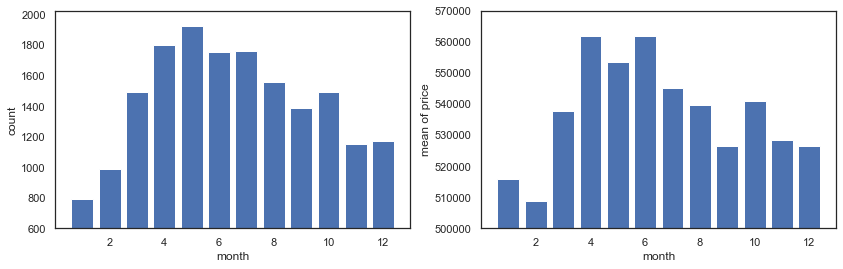

In [110]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
ax[0].bar(month.index, month['count'])
ax[0].set_ylim(600, )
ax[0].set_xlabel('month')
ax[0].set_ylabel('count')
ax[1].bar(month.index, month['mean'])
ax[1].set_ylim(500000, 570000)
ax[1].set_xlabel('month')
ax[1].set_ylabel('mean of price')
#plt.savefig('Images/month.jpeg', format='jpeg')

In [111]:
condlist = [df.month.isin([4,5,6,7]), df.month.isin([1,2,11,12])]
choicelist = ['summer','winter']
df['season'] = np.select(condlist, choicelist, 'spring&fall')

In [112]:
df = pd.get_dummies(df, columns=['season'], prefix='s', drop_first=True)

### Bedrooms

In [113]:
condlist = [df.bedrooms<2, df.bedrooms>5]
choicelist = [1, 6]
df['bed'] = np.select(condlist, choicelist, df.bedrooms)

In [114]:
df = pd.get_dummies(df, columns=['bed'], drop_first=True)

### Condition

In [115]:
df = pd.get_dummies(df, columns=['condition'], prefix='con', drop_first=True)

### Grade

In [116]:
condlist = [df.grade<6, df.grade>10]
choicelist = [5, 11]
df['rating'] = np.select(condlist, choicelist, df.grade)

In [117]:
df = pd.get_dummies(df, columns=['rating'], prefix='r', drop_first=True)

### Sqft_basement

In [118]:
condlist = [df.sqft_basement==0, df.sqft_basement<1000, df.sqft_basement<2000]
choicelist = [0, 1000, 2000]
df['basement'] = np.select(condlist, choicelist, 3000)

In [119]:
df = pd.get_dummies(df, columns=['basement'], prefix='base', drop_first=True)

### Renovate
not renovated: house_age = yr_sold - yr_built  \
renovated: house_age = yr_sold - yr_rebuilt  \
yr_rebuilt = yr_renovated * r + yr_built * (1-r)

In [120]:
r = 0.5
df['age'] = np.where(df.yr_renovated==0, df.year-df.yr_built, df.year-df.yr_renovated*r-df.yr_built*(1-r))

### Zipcode

In [136]:
df = pd.get_dummies(df, columns=['zipcode'], prefix='zip', drop_first=True)

## Interaction Features
Interaction in a non-additive manner when affecting a third variable.

### Bathrooms

In [121]:
df['bath'] = df.bathrooms/df.sqft_living

### Waterfront
Interaction between a binary variable (dummy variable) and a continuous variable

In [122]:
df['water'] = df.waterfront*df.sqft_living15

## Multicollinearity

In [24]:
dfc = df.corr().abs().stack().reset_index().sort_values(0, ascending=False)
dfc['pairs'] = list(zip(dfc.level_0, dfc.level_1))
dfc.set_index(['pairs'], inplace=True)
dfc.drop(columns=['level_1', 'level_0'], inplace=True)
dfc.columns = ['correlation']
dfc.drop_duplicates(inplace=True)
dfc[(dfc.correlation>.75)&(dfc.correlation<1)]

,correlation
pairs,
"(yr_built, age)",0.977603
"(waterfront, water)",0.956799
"(sqft_living, sqft_above)",0.876696
"(con_3, con_4)",0.810849
"(month, year)",0.781982
"(grade, sqft_living)",0.762929
"(grade, sqft_above)",0.758247
"(bathrooms, sqft_living)",0.755270
"(sqft_living, sqft_living15)",0.755066


In [137]:
col = ['id','date','price','bedrooms','bathrooms','floors','waterfront','view','grade','sqft_above','year','month',
       'sqft_basement','yr_built','yr_renovated','lat','long','sqft_living15','sqft_lot', 'sqft_lot15']

In [138]:
target = df.price
dfn = df.drop(columns=col, axis=1)

In [38]:
vif = pd.DataFrame()
vif['features'] = dfn.columns
vif['VIF'] = [variance_inflation_factor(dfn.values, i) for i in range(dfn.shape[1])]
vif.sort_values('VIF', ascending=False)[:10]

,features,VIF
9,con_3,146.805291
10,con_4,60.720157
4,bed_3,47.751721
13,r_7,38.655768
5,bed_4,34.987039
0,sqft_living,31.847450
14,r_8,28.459275
91,bath,20.596255
11,con_5,19.783229
15,r_9,14.139533


# Modeling

## Data Split and Normalization

### Train-Test Split
Perform a train-test split of the data

In [139]:
X_train, X_test, y_train, y_test = train_test_split(dfn, target, random_state=34, test_size=0.31)

### Fit and Transform
Fit the scaler to training the data, and transform the testing set with the scaler.

In [140]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(data=scaler.transform(X_train), columns=dfn.columns)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=dfn.columns)

## Linear Regression
Fit the model to the training data. Use the model to predict on the training set and the test set. Evaluate the training and test predictions using RMSE. Determine if the model is overfit.

In [141]:
lm = LinearRegression()
lm = lm.fit(X_train, y_train)

y_train_pred = lm.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

y_test_pred = lm.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print('Training: R2={}, RMSE={}'.format(r2_train, train_rmse))
print('Testing: R2={}, RMSE={}'.format(r2_test, test_rmse))

Training: R2=0.8165062145864144, RMSE=160803.47455232302
Testing: R2=0.8120040819696698, RMSE=159820.87354808926


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

residuals = y_train-y_train_pred
ax[0].hist(residuals, bins='auto')
ax[0].set_xlabel('residuals')

sns.residplot(y_train, y_train_pred, lowess=True, ax=ax[1])
#plt.savefig('Images/resi.jpeg', format='jpeg')

## Non-linear transformations
polynomial features

In [135]:
for degree in [1, 2]:
    poly = PolynomialFeatures(degree, include_bias=False)
    X_poly_train = poly.fit_transform(X_train)
    reg_poly = LinearRegression().fit(X_poly_train, y_train)   
    y_train_pred = reg_poly.predict(X_poly_train)
    X_poly_test = poly.transform(X_test)
    y_test_pred = reg_poly.predict(X_poly_test)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print('Training: degree={}, R2={}, RMSE={}'.format(degree, r2_train, train_rmse))
    print('Testing: degree={}, R2={}, RMSE={}'.format(degree, r2_test,test_rmse))

Training: degree=1, R2=0.6690680768621922, RMSE=215950.43341366615
Testing: degree=1, R2=0.6596345427835348, RMSE=215046.3271467761
Training: degree=2, R2=0.7406552435748762, RMSE=191171.64810782816
Testing: degree=2, R2=-2.0299084736244752e+17, RMSE=166072421669154.38


## Feature Selection Techniques
Utilize some different feature selection techniques before or in conjuction with fitting the models. Utilize a filter method to identify some features to remove from the model.

### KBest
After removing the features, re-run and see if the new model performs better than the old model. \
hb.polynomial(dfn, target, rs=34, size=0.2, scale=True, degrees=2, r=True)

In [145]:
selector = SelectKBest(f_regression, k=30)
selector.fit(X_train, y_train)

selected_col = X_train.columns[selector.get_support()]
removed_col = X_train.columns[~selector.get_support()]

In [146]:
_ = hb.polynomial(dfn[selected_columns], target)

Training: degree=1, R2=0.7352097676649192, RMSE=191481.06390758045
Testing: degree=1, R2=0.7196291767643076, RMSE=200175.22659699325
Training: degree=2, R2=0.8012257177537198, RMSE=165903.27087991338
Testing: degree=2, R2=-7.308227705177539e+17, RMSE=323184077186030.94


### Forward Selection

In [ ]:
# X_train, X_test, y_train, y_test = hb.polynomial(dfn[selected_columns], target, r=False)
# selected_columns = hb.stepwise_selection(X_train, y_train, verbose=False)

In [ ]:
# model = hb.forward_selected(X_train, y_train)

### RFECV

In [57]:
ols = linear_model.LinearRegression()

selector = RFECV(estimator=ols, step=1, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
selector.fit(X_train, y_train)

selected_rfe = X_train.columns[selector.support_]
removed_rfe = X_train.columns[~selector.support_]

In [58]:
lm_rfe = LinearRegression()
lm_rfe = lm_rfe.fit(X_train[selected_rfe], y_train)

y_rfe = lm_rfe.predict(X_train[selected_rfe])
trainRFE_rmse = np.sqrt(mean_squared_error(y_train, y_rfe))

y_pred_rfe = lm_rfe.predict(X_test[selected_rfe])
testRFE_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfe))

print('Training Root Mean Squared Error:' , trainRFE_rmse)
print('Testing Root Mean Squared Error:' , testRFE_rmse)

Training Root Mean Squared Error: 159444.33417936848
Testing Root Mean Squared Error: 163351.7562007405


## Lasso

In [147]:
X_train, X_test, y_train, y_test = hb.polynomial(dfn[selected_col], target, rs=64, size=0.31, r=False)

In [148]:
lasso = Lasso(alpha=100, normalize=False)
lasso.fit(X_train,y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

train_rmse_lasso = mean_absolute_error(y_train, y_train_pred)
test_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('Training Error: '+ str(train_rmse_lasso))
print('Testing Error: '+ str(test_rmse_lasso))

Training Error: 129228.0904558299
Testing Error: 189772.82940573498


## Ridge

In [ ]:
ridge = Ridge(alpha=1, normalize=False)
ridge.fit(X_train, y_train)
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

train_rmse_ridge = mean_absolute_error(y_train, y_train_pred)
test_rmse_ridge = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('Training Error: '+ str(train_rmse_ridge))
print('Testing Error: '+ str(test_rmse_ridge))

## Refit and Save
Refit the best model to the entire dataset. Save the final model using pickle.

In [ ]:
final_scaler = StandardScaler()
df_final_scaled = pd.DataFrame(data=final_scaler.fit_transform(dfn))
ridge = Ridge(alpha=1, normalize=False)
final = ridge.fit(df_final_scaled, target)

In [ ]:
# with open("model.pickle", "wb") as model:
#     pickle.dump(final, model)

# with open("model.pickle", "wb") as transform:
#     pickle.dump(final_scaler, transform)

pickle_out = open('Data/model.pickle', 'wb')
pickle.dump(final, pickle_out)
pickle_out.close()

pickle_out = open('Data/scaler.pickle', 'wb')
pickle.dump(final_scaler, pickle_out)
pickle_out.close()

# Evaluation

The housing prices is predicted for Kings County in Seattle WA. The model solve the problems for pridiction satisfactorily. New features are created to understand the questions. In any of these cases, it is also totally encouraged to revisit the earlier steps to optimze the features and model techniques.